# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [52]:
X_train = np.loadtxt("./datasets/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/UCI HAR Dataset/test/y_test.txt").astype(int)

In [53]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [54]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [55]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [56]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [58]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [59]:
print(pca.n_components_)

65


Ответ: 65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [60]:
print(round(pca.explained_variance_ratio_[0] * 100))

51


Ответ: 51

Визуализируйте данные в проекции на первые две главные компоненты.

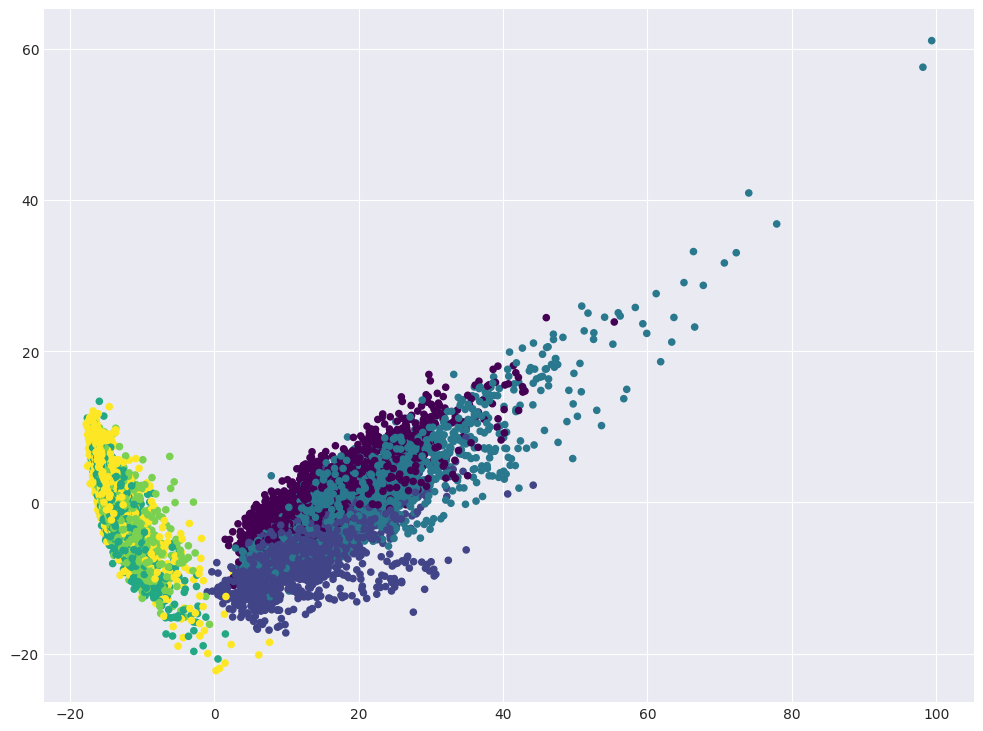

In [61]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

Ответ: 2

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [62]:
class MyKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=None, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        
    def _euclidean_distances(self, X, centroids):
        """Векторизованное вычисление расстояний"""
        return np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    
    def _kmeans_single(self, X):
        """Один запуск KMeans"""
        # Инициализация центроидов
        idx = np.random.choice(len(X), self.n_clusters, replace=False)
        centroids = X[idx].copy()
        
        for _ in range(self.max_iter):
            # E-step: назначение точек к кластерам
            distances = self._euclidean_distances(X, centroids)
            labels = np.argmin(distances, axis=1)
            
            # M-step: обновление центроидов
            new_centroids = np.array([X[labels == k].mean(axis=0) 
                                     if np.any(labels == k) else centroids[k]
                                     for k in range(self.n_clusters)])
            
            # Проверка сходимости
            if np.allclose(centroids, new_centroids, atol=self.tol):
                break
                
            centroids = new_centroids
        
        # Вычисление inertia
        inertia = sum(np.sum((X[labels == k] - centroids[k]) ** 2) 
                     for k in range(self.n_clusters))
        
        return labels, centroids, inertia
    
    def fit_predict(self, X):
        """Обучение с множественными запусками"""
        np.random.seed(self.random_state)
        
        best_inertia = np.inf
        best_labels = None
        best_centroids = None
        
        for _ in range(self.n_init):
            labels, centroids, inertia = self._kmeans_single(X)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels
                best_centroids = centroids
        
        self.labels_ = best_labels
        self.cluster_centers_ = best_centroids
        self.inertia_ = best_inertia
        
        return best_labels

my_kmeans = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
my_labels = my_kmeans.fit_predict(X_pca)

sklearn_kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
sklearn_labels = sklearn_kmeans.fit_predict(X_pca)

print(f"My KMeans inertia: {my_kmeans.inertia_:.2f}")
print(f"Sklearn inertia: {sklearn_kmeans.inertia_:.2f}")
print(f"ARI (сравнение реализаций): {metrics.adjusted_rand_score(my_labels, sklearn_labels):.3f}")


My KMeans inertia: 2003454.20
Sklearn inertia: 2003454.90
ARI (сравнение реализаций): 0.999


In [63]:
kmeans = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

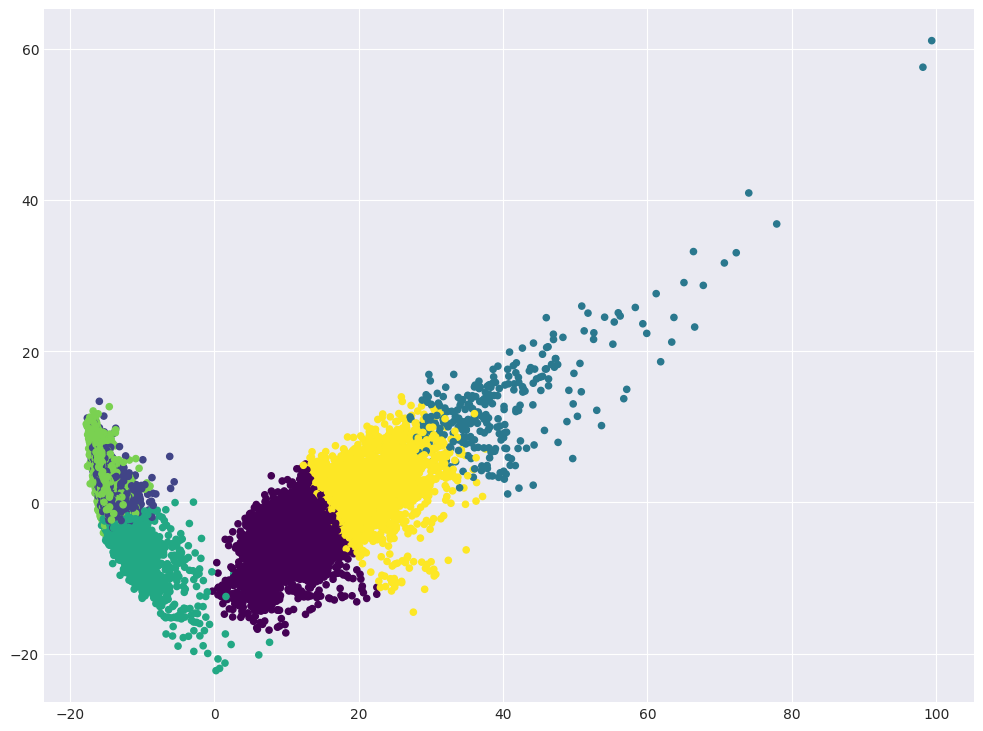

In [64]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [65]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


In [66]:
for i in range(1, 7):
    row = tab.iloc[i-1, :-1]
    max_cluster = row.max()
    total = tab.iloc[i-1, -1]
    ratio = max_cluster / total
    activity_names = ['ходьба', 'подъем вверх', 'спуск', 'сидение', 'стояние', 'лежание']
    print(f"{activity_names[i-1]}: {ratio:.2f}")


ходьба: 0.52
подъем вверх: 0.80
спуск: 0.63
сидение: 0.69
стояние: 0.71
лежание: 0.80


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Ответ:  перечисленные варианты не подходят (лежание и подъем вверх отдлились лучше всего)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


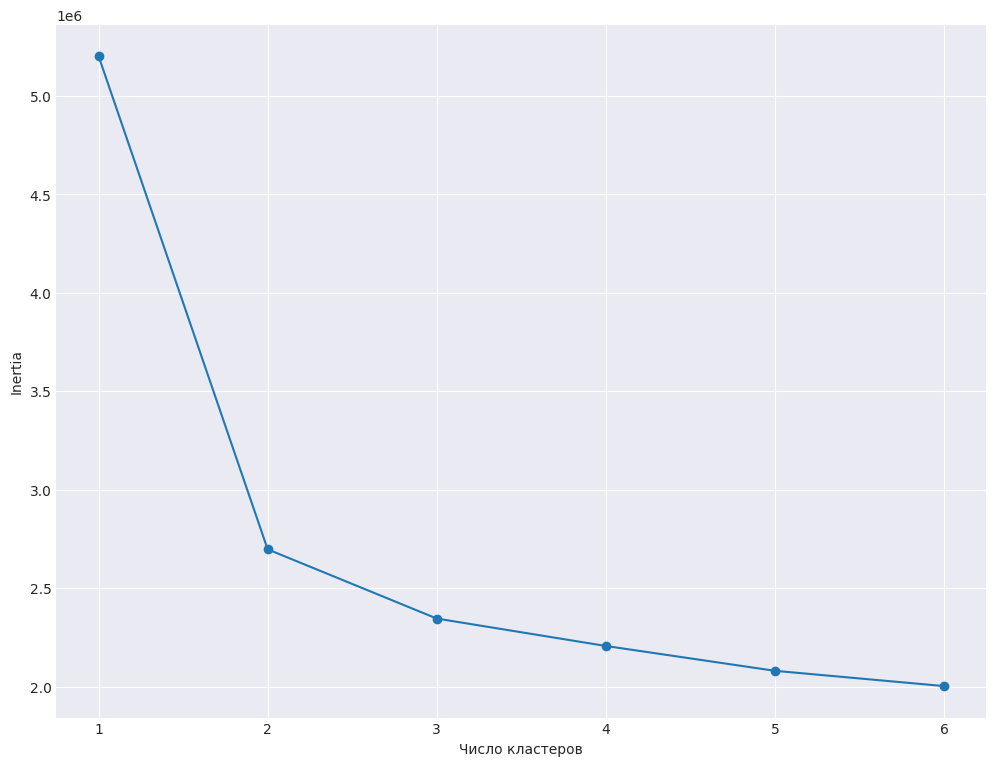

In [67]:
from tqdm import tqdm

inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans_temp.fit(X_pca)
    inertia.append(kmeans_temp.inertia_)


plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

Ответ: 2 (бОльшая точка излома)

------------------------

In [68]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [69]:
kmeans_ari = metrics.adjusted_rand_score(y, cluster_labels)
ag_ari = metrics.adjusted_rand_score(y, ag.labels_)

print(f"KMeans ARI: {kmeans_ari:.3f}")
print(f"Agglomerative ARI: {ag_ari:.3f}")

KMeans ARI: 0.420
Agglomerative ARI: 0.494


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Ответ: Все утверждения верны

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [70]:
scaler_new = StandardScaler()
X_train_scaled = scaler_new.fit_transform(X_train)
X_test_scaled = scaler_new.transform(X_test)

In [71]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [72]:
best_svc = GridSearchCV(svc, svc_params, cv=3)
best_svc.fit(X_train_scaled, y_train)

,estimator,LinearSVC(max...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

Ответ: 0.1

In [73]:
y_predicted = best_svc.predict(X_test_scaled)

In [74]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted, 
                          target_names=['ходьба', 'подъем вверх', 'спуск', 
                                       'сидение', 'стояние', 'лежание']))


              precision    recall  f1-score   support

      ходьба       0.97      1.00      0.98       496
подъем вверх       0.98      0.97      0.98       471
       спуск       1.00      0.98      0.99       420
     сидение       0.96      0.87      0.91       491
     стояние       0.88      0.97      0.92       532
     лежание       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

Ответ: по точности – сидение, по полноте – стояние 
(Сидение имеет precision=0.96. это близко к минимуму. Стояние имеет минимальный precision=0.88. По полноте сидение имеет минимальный recall=0.87)

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [76]:
pca_new = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_new.fit_transform(X_train_scaled)
X_test_pca = pca_new.transform(X_test_scaled)

svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
best_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3)
best_svc_pca.fit(X_train_pca, y_train)

print(f"Лучшее качество БЕЗ PCA: {best_svc.best_score_:.3f}")
print(f"Лучшее качество С PCA: {best_svc_pca.best_score_:.3f}")
print(f"Разница: {round((best_svc.best_score_ - best_svc_pca.best_score_) * 100)}%")


Лучшее качество БЕЗ PCA: 0.938
Лучшее качество С PCA: 0.898
Разница: 4%


Ответ: 4 процента

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

Ответ: второе и третье

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

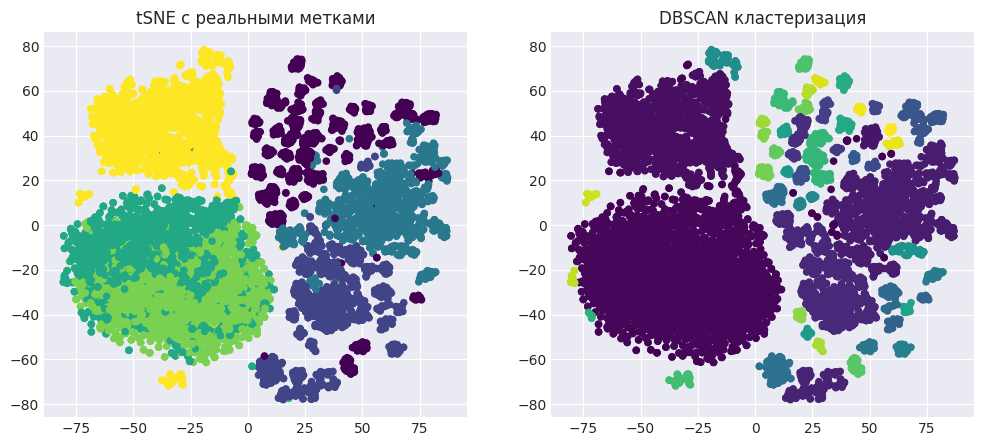

Число кластеров DBSCAN: 53
Число шумовых точек: 127


In [77]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
plt.title('tSNE с реальными метками')

dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.title('DBSCAN кластеризация')
plt.show()

print(f"Число кластеров DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Число шумовых точек: {list(dbscan_labels).count(-1)}")


кластеризация полезна для исследования структуры данных, но не заменяет классификацию при наличии меток.
